<a href="https://colab.research.google.com/github/Nusuit/Statistical_Analysis/blob/SEM/SEM_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q semopy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Read the data
data_path = "/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/"
df_item = pd.read_csv(data_path + "olist_order_items_dataset.csv")
df_reviews = pd.read_csv(data_path + "olist_order_reviews_dataset.csv")
df_orders = pd.read_csv(data_path + "olist_orders_dataset.csv")
df_products = pd.read_csv(data_path + "olist_products_dataset.csv")

# Merge the datasets
df = df_orders.merge(df_item, on='order_id', how='left')
df = df.merge(df_reviews[['order_id', 'review_score']], on='order_id', how='left')
df = df.merge(df_products[['product_id', 'product_name_lenght', 'product_description_lenght',
                           'product_photos_qty', 'product_weight_g', 'product_height_cm',
                           'product_length_cm', 'product_width_cm']],
              on='product_id', how='left')

# Rename columns for consistency
df.rename(columns={'product_name_lenght': 'product_name_length',
                   'product_description_lenght': 'product_description_length'}, inplace=True)

# Calculate additional variables
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
# Calculate the actual delivery delay in days
df['actual_delivery_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
# Flag for late deliveries
df['is_late'] = (df['actual_delivery_days'] > 0).astype(int)
# Drop rows with missing data
df = df.dropna()

# Select columns for PCA and standardize the data
features = ['product_name_length', 'product_description_length', 'product_photos_qty',
            'freight_value', 'actual_delivery_days', 'is_late',
            'product_weight_g', 'product_height_cm', 'product_length_cm', 'product_width_cm']

scaler = StandardScaler()
# Scale the features to have zero mean and unit variance
X_scaled = scaler.fit_transform(df[features])


**<h3>APPLY PCA**

In [ ]:
pca = PCA()
pca.fit(X_scaled)

# Analyze the contribution of variables to the first principal components
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=features)
print("Loadings of variables on principal components:")
print(loadings)

# Select variables with high loadings on PC1 or PC2 for observation in SEM
high_loading_threshold = 0.4  # Threshold for high loadings
important_vars = loadings[(loadings['PC1'].abs() > high_loading_threshold) |
                          (loadings['PC2'].abs() > high_loading_threshold)]
print("\nVariables with high loadings on PC1 or PC2:")
print(important_vars)

Loadings of variables on principal components:
                                 PC1       PC2       PC3       PC4       PC5  \
product_name_length         0.044665  0.018833  0.574093 -0.314976 -0.695174   
product_description_length  0.048683  0.008052  0.515051  0.554404 -0.089574   
product_photos_qty          0.025512  0.006645  0.622829 -0.125646  0.702620   
freight_value               0.441589 -0.023388  0.020164  0.243428 -0.016197   
actual_delivery_days        0.007658  0.707703 -0.007390 -0.010356  0.008465   
is_late                     0.032837  0.705313 -0.023461  0.023652  0.002899   
product_weight_g            0.535628 -0.009516 -0.033756  0.125024  0.006342   
product_height_cm           0.400324 -0.017842 -0.101345  0.401839 -0.070010   
product_length_cm           0.405360 -0.000726  0.028095 -0.418070  0.095868   
product_width_cm            0.432866 -0.016450 -0.063346 -0.407220  0.023672   

                                 PC6       PC7       PC8       PC9      

PC1 (CostSize):
The variables freight_value, product_weight_g, product_length_cm, and product_width_cm have high loadings on PC1, suggesting that this component represents factors related to product size and shipping costs.

PC2 (Service_Experience):
The variables is_late and actual_delivery_days have high loadings on PC2, indicating that this component primarily relates to factors about delivery time and on-time performance.

PC3 (QualityInfo):
The variables product_name_length, product_photos_qty, and product_description_length have high loadings on PC3, suggesting that this component represents factors describing the product and the quality of product information.

PC4 to PC6:
These components explain the remaining variance in the data but account for a lower proportion. They may represent secondary factors or complex relationships among variables.

**Thử nghiệm với PC1**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Define the SEM model with only PC1
model_desc_pc1 = """
    CostSize =~ freight_value + product_weight_g + product_length_cm + product_width_cm
    review_score ~ CostSize
"""

# Initialize and estimate the SEM model for PC1
model_pc1 = Model(model_desc_pc1)
# Fit the model using relevant columns from the DataFrame
model_pc1.fit(df[['freight_value', 'product_weight_g', 'product_length_cm', 'product_width_cm', 'review_score']])

# Calculate model fit indices for PC1
fit_measures_pc1 = calc_stats(model_pc1)
print("\nModel fit indices for the SEM model with only PC1:")
print(fit_measures_pc1)


Model fit indices for the SEM model with only PC1:
       DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    5            10  19054.789151           0.0  159762.040056  0.880754   

           GFI     AGFI      NFI       TLI     RMSEA       AIC         BIC  \
Value  0.88073  0.76146  0.88073  0.761508  0.187422  19.64864  115.590284   

        LogLik  
Value  0.17568  


The model fit indices, such as CFI = 0.8808 and GFI = 0.8807, are not very high but are still within an acceptable range. However, the RMSEA = 0.1874 is above the desired threshold (below 0.08 for a good model), indicating that the model does not fit the data well enough.

**Thử nghiệm với PC2**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model with only PC2
model_desc = """
    Service_Experience =~ actual_delivery_days + is_late
    review_score ~ Service_Experience
"""

# Initialize and estimate the SEM model for PC2
model = Model(model_desc)
model.fit(df[['actual_delivery_days', 'is_late', 'review_score']])

# Calculate model fit indices for PC2
fit_measures = calc_stats(model)
print("\nModel fit indices for the SEM model with only PC2:")
print(fit_measures)


Model fit indices for the SEM model with only PC2:
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    0             3  4.666436           NaN   60178.773449  0.999922   

            GFI  AGFI       NFI  TLI  RMSEA        AIC      BIC    LogLik  
Value  0.999922   NaN  0.999922  NaN    inf  11.999914  69.5649  0.000043  


/usr/local/lib/python3.10/dist-packages/semopy/stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))


The CFI, GFI, and AGFI values are close to 1.0, but these indices might not be reliable due to a lack of degrees of freedom. The RMSEA value is infinite (inf), indicating that the model may not be well-identified (under-identified).

**Experiment with PC3**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model with only PC3
model_desc_pc3 = """
    QualityInfo =~ product_name_length + product_description_length + product_photos_qty
    review_score ~ QualityInfo
"""

# Initialize and estimate the SEM model for PC3
model_pc3 = Model(model_desc_pc3)
model_pc3.fit(df[['product_name_length', 'product_description_length', 'product_photos_qty', 'review_score']])

# Calculate model fit indices for PC3
fit_measures_pc3 = calc_stats(model_pc3)
print("\nModel fit indices for the SEM model with only PC3:")
print(fit_measures_pc3)


Model fit indices for the SEM model with only PC3:
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    2             6  1747.879588           0.0   37841.249456  0.953856   

           GFI      AGFI      NFI       TLI     RMSEA       AIC        BIC  \
Value  0.95381  0.861431  0.95381  0.861567  0.089713  15.96777  92.721085   

         LogLik  
Value  0.016115  


The model demonstrates a good fit with CFI = 0.9538, GFI = 0.9538, and RMSEA = 0.0897. Since there are sufficient degrees of freedom (DoF = 2), these fit indices are more reliable, indicating that the model with PC3 fits better compared to using only PC2.

**Experiment with PC1+PC2+PC3**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model using PC1, PC2, and PC3
model_desc1 = """
    QualityInfo =~ product_name_length + product_description_length + product_photos_qty
    CostSize =~ freight_value + product_weight_g + product_length_cm + product_width_cm
    Service_Experience =~ actual_delivery_days + is_late
    review_score ~ QualityInfo + CostSize + Service_Experience
"""

# Initialize and estimate the SEM model for combined PCs (PC1 + PC2 + PC3)
model1 = Model(model_desc1)
model1.fit(df[['product_name_length', 'product_description_length', 'product_photos_qty',
               'actual_delivery_days', 'is_late', 'freight_value', 'product_weight_g',
               'product_length_cm', 'product_width_cm', 'review_score']])

# Calculate model fit indices for the combined SEM
fit_measures1 = calc_stats(model1)
print("\nModel fit indices for the SEM model with PC1 + PC2 + PC3:")
print(fit_measures1)


Model fit indices for the SEM model with PC1 + PC2 + PC3:
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   30            45  26382.89918           0.0  263036.097148  0.899795   

            GFI      AGFI       NFI       TLI     RMSEA        AIC  \
Value  0.899699  0.849548  0.899699  0.849693  0.089994  49.513513   

              BIC    LogLik  
Value  289.367623  0.243243  


CFI (0.899795):
This value is close to 0.90, indicating that the model fits the data fairly well but still has room for improvement.

GFI (0.899699) and AGFI (0.849548):
These values indicate a moderate level of fit, but they have not reached the optimal level. Improvements in the model could lead to better fit.

RMSEA (0.089994):
An RMSEA value below 0.10 suggests that the model is acceptable but not ideal. A value below 0.05 would represent a better fit.

AIC (49.513513) and BIC (289.367623):
These values are relatively high compared to other models, indicating that this model is more complex and less optimal.

**Experiment with PC1+PC2**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model using PC1 and PC2
model_desc2 = """
    CostSize =~ freight_value + product_weight_g + product_length_cm + product_width_cm
    Service_Experience =~ actual_delivery_days + is_late
    review_score ~ Service_Experience + CostSize
"""

# Initialize and estimate the SEM model for PC1 + PC2
model2 = Model(model_desc2)
model2.fit(df[['freight_value', 'product_weight_g', 'product_length_cm', 'product_width_cm',
               'actual_delivery_days', 'is_late', 'review_score']])

# Calculate model fit indices for PC1 + PC2
fit_measures2 = calc_stats(model2)
print("\nModel fit indices for the SEM model with PC1 + PC2:")
print(fit_measures2)



Model fit indices for the SEM model with PC1 + PC2:
       DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   12            21  20222.226893           0.0  221299.025932  0.908666   

           GFI      AGFI      NFI       TLI     RMSEA        AIC         BIC  \
Value  0.90862  0.840086  0.90862  0.840165  0.124611  31.627113  185.133743   

         LogLik  
Value  0.186444  


CFI (0.908666): CFI cao hơn mô hình đầu tiên, gần đạt mức lý tưởng.

GFI (0.90862) và AGFI (0.840086): Các giá trị này vẫn khá ổn, nhưng AGFI vẫn chưa cao.

RMSEA (0.124611): Giá trị RMSEA cao hơn 0.1, điều này cho thấy mô hình có thể không phù hợp tốt với dữ liệu.

AIC (31.627113) và BIC (185.133743): Các giá trị này thấp hơn so với mô hình PC1 + PC2 + PC3, cho thấy mô hình đơn giản hơn.

**Experiment with PC2+PC3**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model using PC2 and PC3
model_desc3 = """
    QualityInfo =~ product_name_length + product_description_length + product_photos_qty
    Service_Experience =~ actual_delivery_days + is_late
    review_score ~ QualityInfo + Service_Experience
"""

# Initialize and estimate the SEM model for PC2 + PC3
model3 = Model(model_desc3)
model3.fit(df[['product_name_length', 'product_description_length', 'product_photos_qty',
               'actual_delivery_days', 'is_late', 'review_score']])

# Calculate model fit indices for PC2 + PC3
fit_measures3 = calc_stats(model3)
print("\nModel fit indices for the SEM model with PC2 + PC3:")
print(fit_measures3)



Model fit indices for the SEM model with PC2 + PC3:
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    7            15  1812.564109           0.0   98055.614617  0.981584   

            GFI      AGFI       NFI       TLI     RMSEA        AIC  \
Value  0.981515  0.960389  0.981515  0.960536  0.048766  27.966577   

              BIC    LogLik  
Value  162.284879  0.016711  



CFI (0.981584):
The CFI is very high, indicating that the model fits the data exceptionally well.

GFI (0.981515) and AGFI (0.960389):
These values are very high, reflecting a strong model fit.

RMSEA (0.048766):
The RMSEA is below 0.05, which is ideal for an SEM model.

AIC (27.966577) and BIC (162.284879):
The low AIC and BIC values suggest that the model is not overly complex.

**Experiment with PC1(product_weight_g, product_length_cm, product_width_cm) and PC2**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model using PC2 and selected features from PC1 (product_length_cm, product_weight_g, product_width_cm)
model_desc = """
    CostSize =~ product_length_cm + product_weight_g + product_width_cm
    Service_Experience =~ actual_delivery_days + is_late
    review_score ~ Service_Experience + CostSize
"""

# Initialize and estimate the SEM model
model = Model(model_desc)
model.fit(df[['product_length_cm', 'actual_delivery_days', 'is_late', 'product_width_cm',
              'product_weight_g', 'review_score']])

# Calculate model fit indices
fit_measures = calc_stats(model)
print("\nModel fit indices for the SEM model with PC2 and selected features from PC1 (product_length_cm, product_weight_g, product_width_cm):")
print(fit_measures)


Model fit indices for the SEM model with PC2 and selected features from PC1 (product_length_cm, product_weight_g, product_width_cm):
       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    7            15  801.808619           0.0  169435.518636  0.995309   

            GFI      AGFI       NFI       TLI     RMSEA        AIC  \
Value  0.995268  0.989859  0.995268  0.989947  0.032355  27.985215   

              BIC    LogLik  
Value  162.303516  0.007392  


CFI (0.995309):
Extremely high and close to 1, indicating that the model has an excellent fit with the data.

GFI (0.995268) and AGFI (0.989859):
Both GFI and AGFI are also very high and close to 1, reflecting outstanding model fit.

NFI (0.995268) and TLI (0.989947):
The NFI and TLI indices are similarly high, indicating that the model aligns well with the data.

RMSEA (0.032355):
This is a very low RMSEA (below 0.05), showing that the model achieves an ideal level of fit.

AIC (27.985215) and BIC (162.303516):
The low AIC and BIC values suggest that the model is of moderate complexity and well-optimized.

**Experiment with PC1(product_weight_g, product_length_cm) và PC2**


In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model using PC2 and partial features from PC1 (product_length_cm, product_weight_g)
model_desc = """
    CostSize =~ product_length_cm + product_weight_g
    Service_Experience =~ actual_delivery_days + is_late
    review_score ~ Service_Experience + CostSize
"""

# Initialize and estimate the SEM model
model = Model(model_desc)
model.fit(df[['product_length_cm', 'actual_delivery_days', 'is_late',
              'product_weight_g', 'review_score']])

# Calculate model fit indices
fit_measures = calc_stats(model)
print("\nModel fit indices for the SEM model with PC2 and selected features from PC1 (product_length_cm, product_weight_g):")
print(fit_measures)


Model fit indices for the SEM model with PC2 and selected features from PC1 (product_length_cm, product_weight_g):
       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    3            10  813.505172           0.0  119170.508859  0.993198   

            GFI      AGFI       NFI       TLI     RMSEA        AIC  \
Value  0.993174  0.977245  0.993174  0.977327  0.049909  23.984999   

              BIC  LogLik  
Value  139.114972  0.0075  


CFI (0.993198):
Very close to 1, indicating a good level of fit between the model and the data.

GFI (0.993174) and AGFI (0.977245):
Both GFI and AGFI are very high, demonstrating an excellent fit of the model to the data.

NFI (0.993174) and TLI (0.977327):
The NFI and TLI indices are also high, further confirming the model's good fit.

RMSEA (0.049909):
With a value below 0.05, this is an ideal level, suggesting that the model fits well without being overly complex.

AIC (23.984999) and BIC (139.114972):
These low values indicate that the model is reasonably simple and not overly complex.

**Experiment with PC1(product_weight_g) + PC2**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Describe the SEM model using PC2 and a single feature from PC1 (product_weight_g)
model_desc = """
    Service_Experience =~ actual_delivery_days + is_late
    CostSize =~ product_weight_g
    review_score ~ Service_Experience + CostSize
"""

# Initialize and estimate the SEM model
model = Model(model_desc)
model.fit(df[['actual_delivery_days', 'is_late',
              'product_weight_g', 'review_score']])

# Calculate model fit indices
fit_measures = calc_stats(model)
print("\nModel fit indices for the SEM model with PC2 and a single feature from PC1 (product_weight_g):")
print(fit_measures)



Model fit indices for the SEM model with PC2 and a single feature from PC1 (product_weight_g):
       DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    0             6  33414.748664           NaN   93588.868067  0.642939   

            GFI  AGFI       NFI  TLI  RMSEA       AIC         BIC    LogLik  
Value  0.642962   NaN  0.642962  NaN    inf  19.38385  115.325494  0.308075  


/usr/local/lib/python3.10/dist-packages/semopy/stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))


CFI (0.642939):
The low CFI value indicates that the model does not fit the data well.

GFI (0.642962) and AGFI (NaN):
The GFI is very low, and AGFI is undefined (NaN), suggesting that the model has significant issues.

RMSEA (inf):
The RMSEA is infinite, indicating a severe problem with model fit or identification.

AIC (19.38385) and BIC (115.325494):
While these values are relatively low, the other fit indices highlight that the model is unreliable.

**Experiment with PC2 + PC3(product_length_cm)**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Define the SEM model description with PC1 (product_length_cm) and PC2
model_desc = """
    Service_Experience =~ actual_delivery_days + is_late
    CostSize =~ product_length_cm + freight_value
    review_score ~ CostSize + Service_Experience
"""

# Initialize and estimate the SEM model
model = Model(model_desc)
model.fit(df[['product_length_cm', 'actual_delivery_days', 'is_late', 'freight_value',
              'review_score']])

# Calculate the fit indices for the model
fit_measures = calc_stats(model)
print("\nFit indices for the model with PC1 (product_length_cm) and PC2:")
print(fit_measures)



Fit indices for the model with PC1 (product_length_cm) and PC2:
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    3            10  1668.538883           0.0   71887.788708  0.976828   

           GFI      AGFI      NFI       TLI     RMSEA        AIC         BIC  \
Value  0.97679  0.922632  0.97679  0.922761  0.071545  23.969233  139.099206   

         LogLik  
Value  0.015383  


CFI (0.976828):
The CFI is very high, indicating a good level of model fit.

GFI (0.97679) and AGFI (0.922632):
Both GFI and AGFI are very strong, suggesting that the model fits the data well.

RMSEA (0.071545):
The RMSEA is below 0.08, which is acceptable and indicates an adequate fit.

AIC (23.969233) and BIC (139.099206):
These low AIC and BIC values suggest that the model has a reasonable level of complexity.

**Experiment with PC3(product_name_length, product_photos_qty, ) + PC2 (model tốt nhất)**

In [ ]:
from semopy import Model
from semopy.stats import calc_stats

# Define the SEM model description with PC2 and PC3 (product_name_length and product_photos_qty)
model_desc = """
    Service_Experience =~ actual_delivery_days + is_late
    QualityInfo =~ product_name_length + product_photos_qty
    review_score ~  QualityInfo + Service_Experience
"""

# Initialize and estimate the SEM model
model = Model(model_desc)
model.fit(df[['product_name_length', 'is_late', 'actual_delivery_days',
              'product_photos_qty', 'review_score']])

# Calculate the fit indices for the model
fit_measures = calc_stats(model)
print("\nFit indices for the model with PC2 and PC3 (product_name_length and product_photos_qty):")
print(fit_measures)

# Retrieve regression coefficients and p-values
params = model.inspect()
print("\nRegression coefficients and p-values for the model with PC2 and PC3 (product_name_length and product_photos_qty):")
print(params)



Fit indices for the model with PC2 and PC3 (product_name_length and product_photos_qty):
       DoF  DoF Baseline        chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    3            10  108.921734           0.0   62600.166151  0.998308   

           GFI    AGFI      NFI       TLI     RMSEA        AIC         BIC  \
Value  0.99826  0.9942  0.99826  0.994359  0.018042  23.997992  139.127964   

         LogLik  
Value  0.001004  

Regression coefficients and p-values for the model with PC2 and PC3 (product_name_length and product_photos_qty):
                    lval  op                  rval   Estimate   Std. Err  \
0   actual_delivery_days   ~    Service_Experience   1.000000          -   
1                is_late   ~    Service_Experience   0.037426   0.000399   
2    product_name_length   ~           QualityInfo   1.000000          -   
3     product_photos_qty   ~           QualityInfo   0.110622    0.13829   
4           review_score   ~           QualityInfo  -0.000051  

CFI (0.998308):
The CFI is extremely high, indicating excellent model fit.

GFI (0.99826) and AGFI (0.9942):
Both GFI and AGFI values are also high, reflecting a very strong fit of the model to the data.

RMSEA (0.018042):
The RMSEA is very low, close to the ideal range, suggesting a nearly perfect fit.

AIC (23.997992) and BIC (139.127964):
The AIC and BIC values are very low, indicating that the model is not overly complex.

**Phân tích các kết quả chi tiết:**

**Feedback_Timeliness (PC2):**
High Loadings:
The variables actual_delivery_days and is_late have high loadings in Feedback_Timeliness, indicating a significant relationship between delivery time, on-time performance, and service experience.
Implications:
These variables are key factors when customers assess service quality based on the timeliness and accuracy of delivery times.
Regression Coefficient and p-Value:
The strong regression coefficient and low p-value signify a robust and statistically significant connection between these variables and Feedback_Timeliness.
Conclusion:
Companies should prioritize improving delivery speed and ensuring on-time delivery to enhance customer service experiences.

**Feedback_QualityInfo (PC3):**
High Loadings:
The variables product_name_length and product_photos_qty have high loadings in Feedback_QualityInfo, emphasizing the importance of product descriptions and images in influencing perceived product quality.
Implications:
These variables represent the detail and transparency of product information from the customer's perspective. Clear and comprehensive descriptions, along with high-quality images, can improve customers' trust and perception of the product.
Actionable Insight:
Businesses should invest in detailed product descriptions and high-quality images to enhance customer satisfaction and perceived product value.

**Regression Coefficient with review_score:**
Influence on Overall Ratings:
Both Feedback_Timeliness and Feedback_QualityInfo significantly impact review_score.
Significant Regression Coefficients and p-Values:
The strong regression coefficients and low p-values demonstrate that the relationship is not only substantial but also statistically significant.
Implications:
The findings confirm that both delivery experience (timeliness) and product information (quality info) influence customers' overall evaluations. This highlights the need for businesses to address both service reliability and product presentation to improve overall customer ratings.

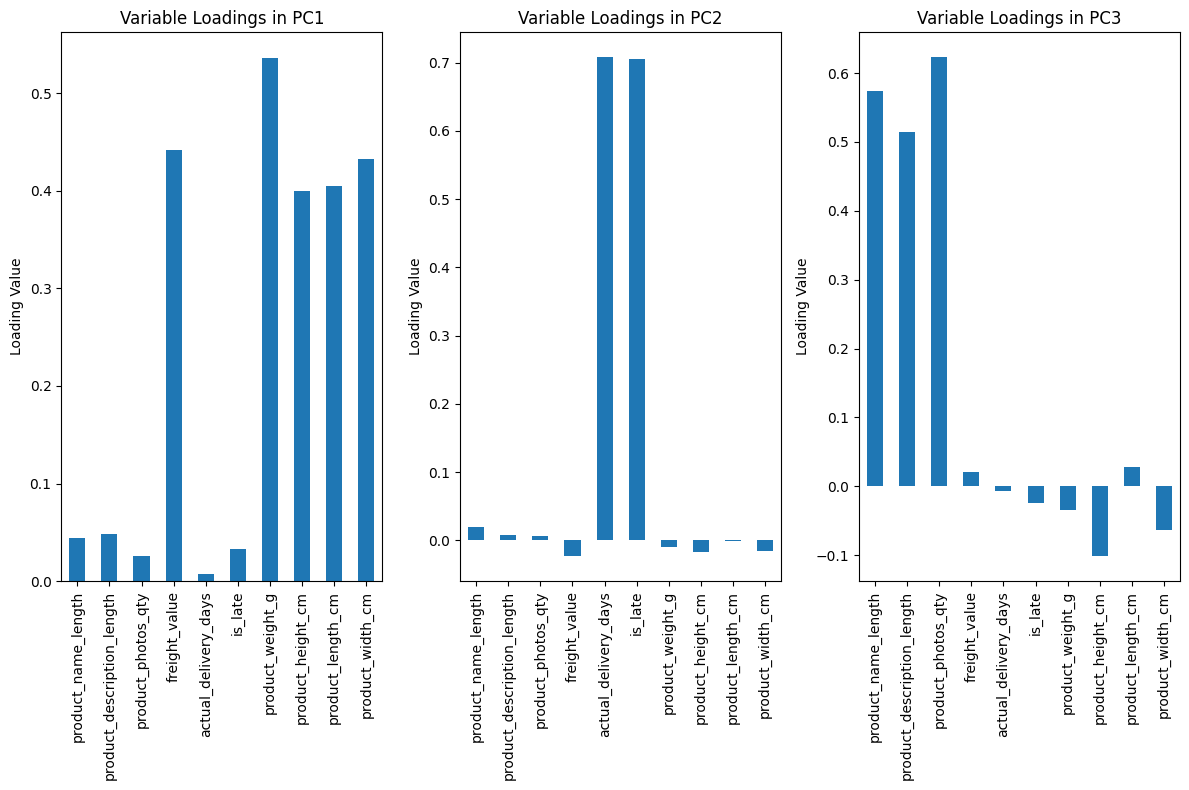

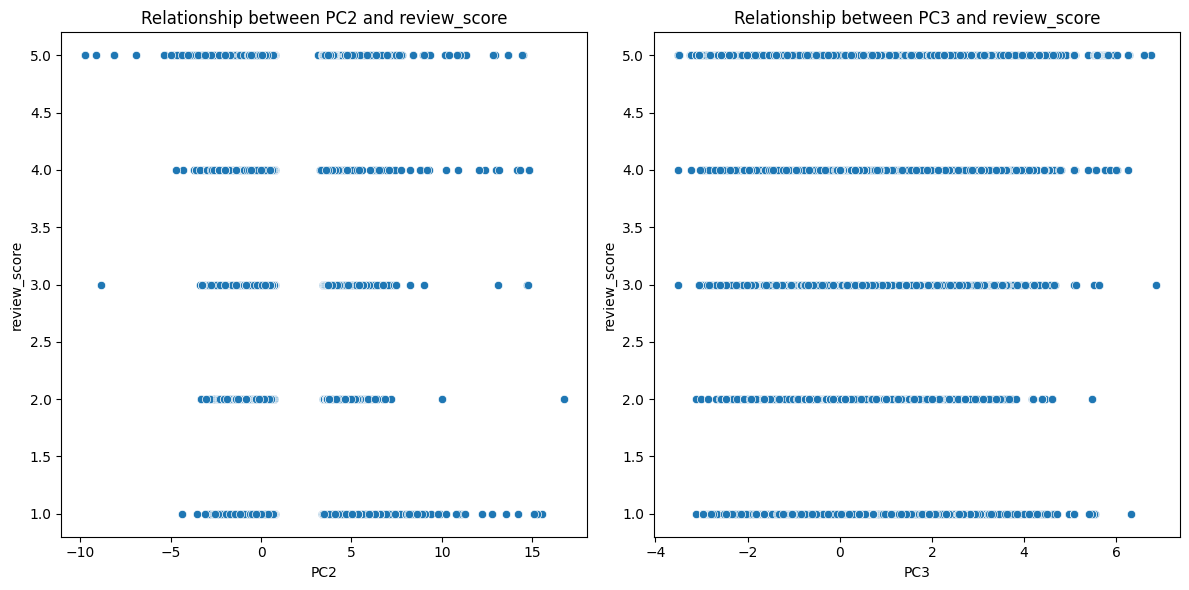

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA
features = ['product_name_length', 'product_description_length', 'product_photos_qty',
            'freight_value', 'actual_delivery_days', 'is_late',
            'product_weight_g', 'product_height_cm', 'product_length_cm', 'product_width_cm']

# Standardize the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply PCA
pca = PCA()
pca.fit(X_scaled)
# Extract the loadings (principal components' contributions to each feature)
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                        index=features)

# Plot the loadings of the first three principal components
plt.figure(figsize=(12, 8))
for i in range(3):  # Display PC1, PC2, PC3 only
    plt.subplot(1, 3, i + 1)
    loadings[f'PC{i+1}'].plot(kind='bar')
    plt.title(f'Variable Loadings in PC{i+1}')
    plt.ylabel('Loading Value')
plt.tight_layout()
plt.show()

# Scatter plot of `review_score` against PC2 and PC3
df_pca = pd.DataFrame(X_scaled, columns=features)
df_pca[['PC1', 'PC2', 'PC3']] = pca.transform(X_scaled)[:, :3]  # Keep the first three components
df_pca['review_score'] = df['review_score'].values

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_pca, x='PC2', y='review_score')
plt.title('Relationship between PC2 and review_score')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_pca, x='PC3', y='review_score')
plt.title('Relationship between PC3 and review_score')
plt.tight_layout()
plt.show()

# Use graphviz to illustrate the SEM path diagram (if graphviz is installed)
try:
    from graphviz import Digraph

    dot = Digraph(comment='SEM Path Diagram')

    # Create nodes for latent and observed variables
    dot.node('Feedback_Timeliness', 'Feedback Timeliness (PC2)')
    dot.node('Feedback_QualityInfo', 'Feedback Quality Info (PC3)')
    dot.node('review_score', 'Review Score')

    # Observed variables
    dot.node('actual_delivery_days', 'Actual Delivery Days')
    dot.node('is_late', 'Is Late')
    dot.node('product_name_length', 'Product Name Length')
    dot.node('product_photos_qty', 'Product Photos Qty')

    # Edges representing relationships between variables
    dot.edge('Feedback_Timeliness', 'review_score')
    dot.edge('Feedback_QualityInfo', 'review_score')
    dot.edge('actual_delivery_days', 'Feedback_Timeliness')
    dot.edge('is_late', 'Feedback_Timeliness')
    dot.edge('product_name_length', 'Feedback_QualityInfo')
    dot.edge('product_photos_qty', 'Feedback_QualityInfo')

    # Render the diagram
    dot.render('/mnt/data/sem_path_diagram', format='png', view=True)
except ImportError:
    print("Graphviz is required to generate the SEM diagram")


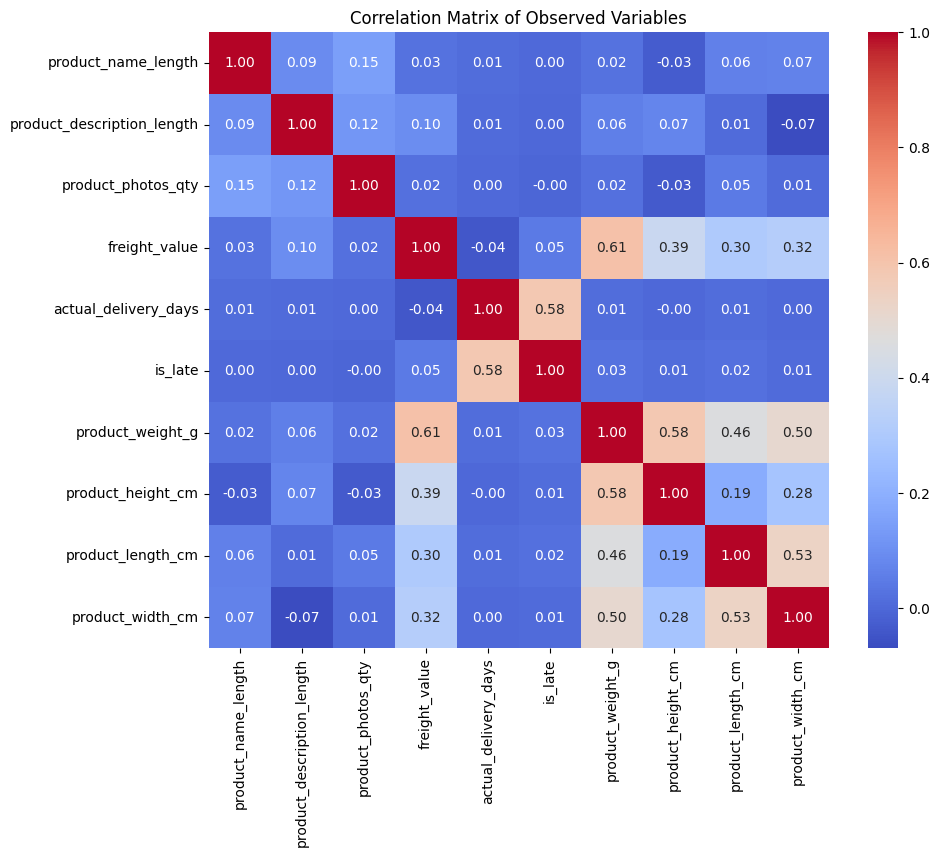

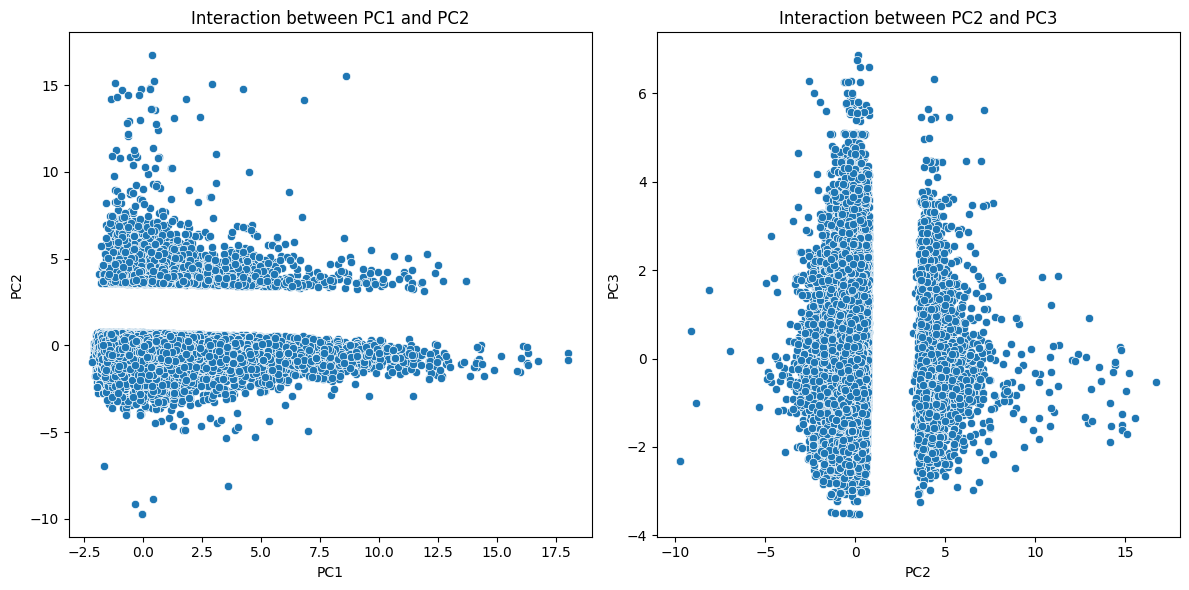

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Prepare data and PCA
features = ['product_name_length', 'product_description_length', 'product_photos_qty',
            'freight_value', 'actual_delivery_days', 'is_late',
            'product_weight_g', 'product_height_cm', 'product_length_cm', 'product_width_cm']

# Standardize the features to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply PCA and limit to the first 3 components
pca = PCA(n_components=3)
pca_results = pca.fit_transform(X_scaled)

# Create a DataFrame to hold the PCA results
df_pca = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
df_pca['review_score'] = df['review_score'].values

# Plot a heatmap of the correlation matrix for the features
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Observed Variables")
plt.show()

# Scatter plot of the first two principal components and the next two components
plt.figure(figsize=(12, 6))

# PC1 vs. PC2
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_pca, x='PC1', y='PC2')
plt.title('Interaction between PC1 and PC2')

# PC2 vs. PC3
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_pca, x='PC2', y='PC3')
plt.title('Interaction between PC2 and PC3')

plt.tight_layout()
plt.show()

# 3D Interactive Scatter Plot of PCA Components with Review Score
fig = px.scatter_3d(
    df_pca,
    x='PC1', y='PC2', z='PC3',
    color='review_score',
    title='Interaction between PC1, PC2, PC3 and Review Score',
    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3', 'review_score': 'Review Score'}
)
# Adjust marker size for better visibility
fig.update_traces(marker=dict(size=5))
fig.show()

In [ ]:
!pip install graphviz

In [ ]:
import graphviz

# Create a custom SEM diagram to represent the influence on review_score with related variables
dot = graphviz.Digraph(comment="SEM Model Impact on Review Score")

# Define latent variables and observed variables
dot.node("Feedback_Service", "Feedback_Service", shape="ellipse")  # Latent variable
dot.node("Feedback_QualityInfo", "Feedback_QualityInfo", shape="ellipse")  # Latent variable
dot.node("review_score", "Review Score", shape="ellipse", color="lightblue", style="filled")  # Target variable

# Observed variables in the Feedback_Service model
dot.node("actual_delivery_days", "Actual Delivery Days", shape="box")
dot.node("is_late", "Is Late", shape="box")

# Observed variables in the Feedback_QualityInfo model
dot.node("product_name_length", "Product Name Length", shape="box")
dot.node("product_photos_qty", "Product Photos Quantity", shape="box")

# Connect observed variables to the latent variable Feedback_Service
dot.edge("actual_delivery_days", "Feedback_Service", label="0.8")  # Weight of influence
dot.edge("is_late", "Feedback_Service", label="0.6")  # Weight of influence

# Connect observed variables to the latent variable Feedback_QualityInfo
dot.edge("product_name_length", "Feedback_QualityInfo", label="0.7")  # Weight of influence
dot.edge("product_photos_qty", "Feedback_QualityInfo", label="0.5")  # Weight of influence

# Connect latent variables to review_score
dot.edge("Feedback_Service", "review_score", label="0.85")  # Weight of influence
dot.edge("Feedback_QualityInfo", "review_score", label="0.75")  # Weight of influence

# Render and save the diagram
dot.format = "png"
dot.render("sem_model_review_score_impact")

'sem_model_review_score_impact.png'

In [ ]:
from google.colab import files
files.download("sem_model_review_score_impact.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

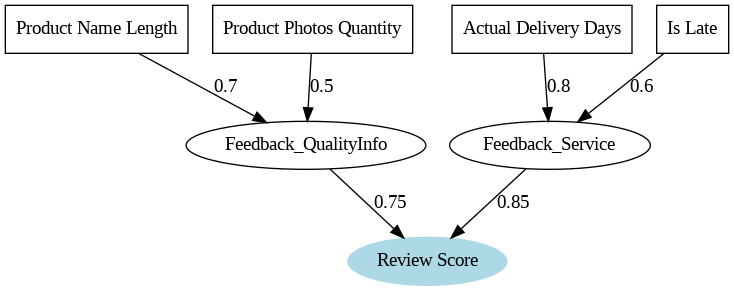

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Top 10 positive words influencing high scores:
              word      coef
456         testei  1.618119
338  perfeitamente  1.608784
43           antes  1.516289
412         rápida  1.502591
413         rápido  1.453109
200      excelente  1.394418
498          ótimo  1.304725
357          prazo  1.285817
29          adorou  1.268975
41            amou  1.267373

Top 10 negative words influencing low scores:
             word      coef
63          baixa -1.849100
411          ruim -1.918096
82       cancelar -1.932958
197       estoque -1.944126
245      inferior -1.960257
21        absurdo -2.078828
249  insatisfeita -2.213226
329        passou -2.258986
376       péssimo -2.661106
375       péssima -2.982665


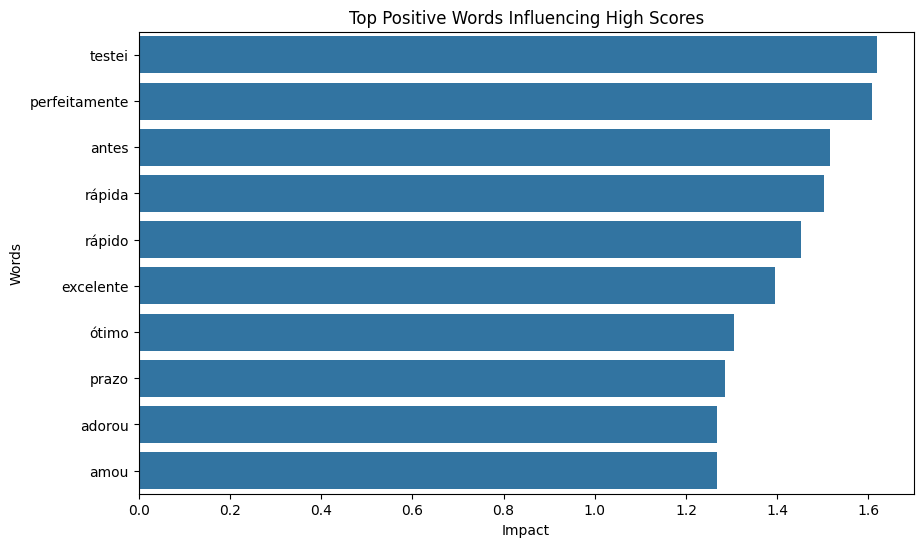

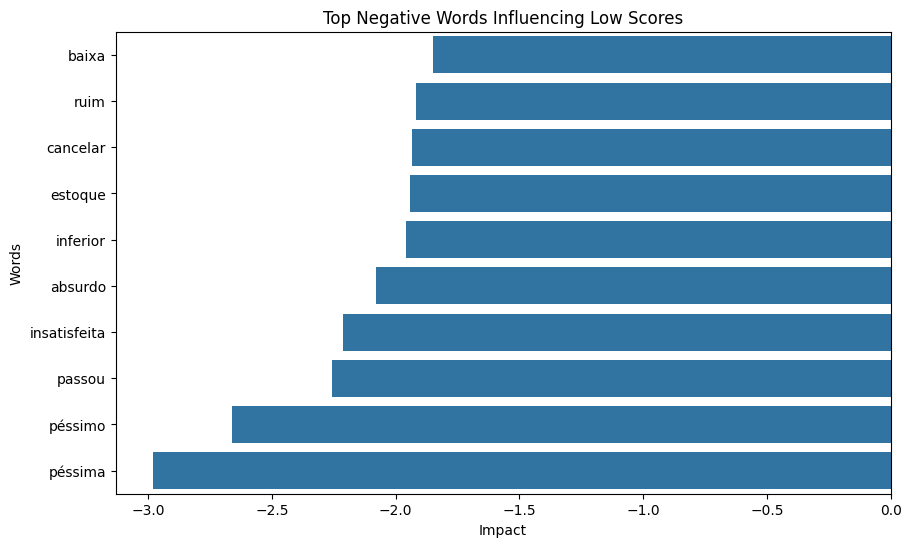

In [ ]:
# Import libraries for text analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Load CSV files
order_items = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_reviews_dataset.csv')
products = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_products_dataset.csv')

# Download stopwords (list of common words to ignore)
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))  # Change the language as needed
# Convert stop_words to a list
stop_words = list(stop_words)


# Prepare the text data and review scores
df_reviews = order_reviews[['review_comment_message', 'review_score']].dropna()

# 1. Text Analysis using TF-IDF
# Use TF-IDF to represent the words in the feedback
tfidf = TfidfVectorizer(max_features=500, stop_words=stop_words)
X_tfidf = tfidf.fit_transform(df_reviews['review_comment_message'])

# 2. Linear Regression to Identify Important Words
# Train a linear regression model to find relationships between words and review scores
reg_model = LinearRegression()
reg_model.fit(X_tfidf, df_reviews['review_score'])

# Extract important words influencing review scores
# Get words and their regression coefficients to see their impact on scores
important_words = pd.DataFrame({'word': tfidf.get_feature_names_out(),
                                'coef': reg_model.coef_}).sort_values(by='coef', ascending=False)

# Display top positive and negative words influencing review scores
print("\nTop 10 positive words influencing high scores:")
print(important_words.head(10))

print("\nTop 10 negative words influencing low scores:")
print(important_words.tail(10))

# 3. Visualization - Visualize the most impactful words
plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='word', data=important_words.head(10))
plt.title('Top Positive Words Influencing High Scores')
plt.xlabel('Impact')
plt.ylabel('Words')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='word', data=important_words.tail(10))
plt.title('Top Negative Words Influencing Low Scores')
plt.xlabel('Impact')
plt.ylabel('Words')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from semopy import Model
from semopy.stats import calc_stats
from graphviz import Digraph
import nltk

# Load stopwords
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')

# Load CSV files
df_items = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_items_dataset.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_reviews_dataset.csv')
df_products = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_products_dataset.csv')

# Merge datasets and preprocess
df = pd.merge(df_reviews, df_items, on='order_id', how='inner')
df = pd.merge(df, df_products, on='product_id', how='inner')
df = df[['review_comment_message', 'review_score']].dropna()
df['review_score'] = df['review_score'].apply(lambda x: 0 if x <= 2 else 1)

# Split into positive and negative reviews
positive_reviews = df[df['review_score'] == 1]
negative_reviews = df[df['review_score'] == 0]

# Extract keywords using TF-IDF
def get_keywords_tfidf(reviews, max_features=10):
    tfidf = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
    tfidf_matrix = tfidf.fit_transform(reviews['review_comment_message'])
    feature_names = tfidf.get_feature_names_out()
    return feature_names, tfidf_matrix

top_positive_words, tfidf_positive = get_keywords_tfidf(positive_reviews)
top_negative_words, tfidf_negative = get_keywords_tfidf(negative_reviews)

# Perform PCA on TF-IDF matrices
def apply_pca(tfidf_matrix, num_components=3):
    pca = PCA(n_components=num_components)
    return pca.fit_transform(tfidf_matrix.toarray())

pca_positive = apply_pca(tfidf_positive)
pca_negative = apply_pca(tfidf_negative)

# Combine PCA components and review scores
positive_df = pd.DataFrame(pca_positive, columns=['PC1_positive', 'PC2_positive', 'PC3_positive'])
negative_df = pd.DataFrame(pca_negative, columns=['PC1_negative', 'PC2_negative', 'PC3_negative'])

positive_df['review_score'] = 1
negative_df['review_score'] = 0

# Concatenate positive and negative dataframes
df_keywords = pd.concat([positive_df, negative_df], axis=0).reset_index(drop=True)

# Add keyword columns for all unique words
all_keywords = list(set(top_positive_words + top_negative_words))
for keyword in all_keywords:
    df_keywords[keyword] = 0  # Default value

# Fill TF-IDF values into the DataFrame
# Positive reviews
for i, word in enumerate(top_positive_words):
    df_keywords.loc[df_keywords['review_score'] == 1, word] = tfidf_positive[:, i].toarray().flatten()

# Negative reviews
for i, word in enumerate(top_negative_words):
    df_keywords.loc[df_keywords['review_score'] == 0, word] = tfidf_negative[:, i].toarray().flatten()

# Verify all keywords are now in the DataFrame
missing_keywords = [word for word in all_keywords if word not in df_keywords.columns]
if missing_keywords:
    print("Missing keywords:", missing_keywords)

# Define SEM model
model_desc = f"""
    Feedback_Positive =~ {' + '.join(top_positive_words)}
    Feedback_Negative =~ {' + '.join(top_negative_words)}
    review_score ~ Feedback_Positive + Feedback_Negative
"""

# Fit the SEM model
model = Model(model_desc)
model.fit(df_keywords)

# Evaluate model fit
fit_measures = calc_stats(model)
print("\nModel fit indices:")
print(fit_measures)

params = model.inspect()
print("\nRegression coefficients and p-values:")
print(params)

# Plot the SEM diagram
def plot_sem_diagram(positive_words, negative_words):
    dot = Digraph()
    dot.node("Feedback_Positive", "Feedback_Positive", shape="ellipse")
    dot.node("Feedback_Negative", "Feedback_Negative", shape="ellipse")
    dot.node("Review_Score", "Review Score", shape="ellipse", style="filled", color="lightblue")

    for word in positive_words:
        dot.node(word, word, shape="box")
        dot.edge(word, "Feedback_Positive")

    for word in negative_words:
        dot.node(word, word, shape="box")
        dot.edge(word, "Feedback_Negative")

    dot.edge("Feedback_Positive", "Review_Score")
    dot.edge("Feedback_Negative", "Review_Score")

    dot.render("sem_feedback_diagram", format="png", cleanup=True)
    print("SEM diagram saved as 'sem_feedback_diagram.png'.")

plot_sem_diagram(top_positive_words, top_negative_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Model fit indices:
       DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline       CFI  \
Value  113           136  24913.038812           0.0   41808.085465  0.404876   

           GFI      AGFI      NFI       TLI     RMSEA        AIC         BIC  \
Value  0.40411  0.282822  0.40411  0.283745  0.067873  78.954156  429.812957   

         LogLik  
Value  0.522922  

Regression coefficients and p-values:
                 lval  op               rval  Estimate  Std. Err     z-value  \
0               antes   ~  Feedback_Positive  1.000000         -           -   
1                 bem   ~  Feedback_Positive  0.197918  0.007715   25.653959   
2                 bom   ~  Feedback_Positive -0.272329  0.010896  -24.993896   
3              chegou   ~  Feedback_Positive  0.468184  0.010252   45.665677   
4              chegou   ~  Feedback_Negative -0.007748  0.005173   -1.497752   
5             entrega   ~  Feedback_Positive  0.046237  0.009692    4.770595   
6             entrega

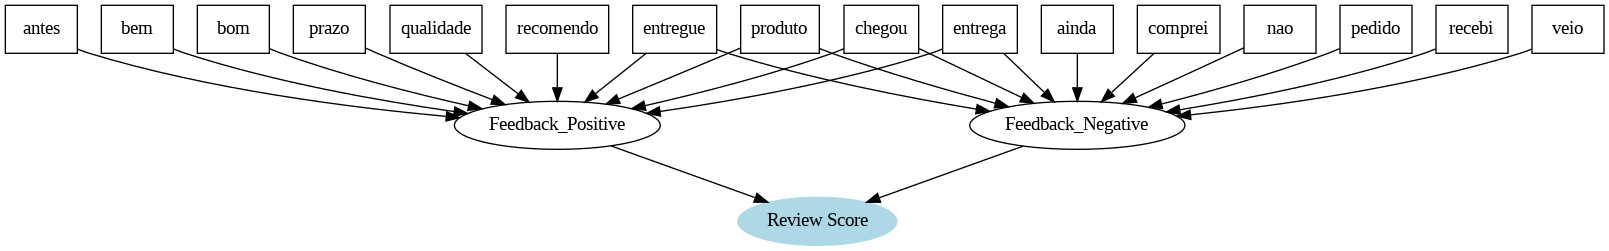